In [1]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(pathlib.Path.cwd()).parent))
import arviz as az
import matplotlib.pyplot as plt  # For showing plots

import baseball_simulator.config as config
from baseball_simulator.model_loader import ModelLoader  # Your model loader


In [2]:
# --- Load idata ---
# Adjust paths as per your setup in config.py
loader = ModelLoader()
loader.set_paths(
    base_dir='../baseball_simulator', # Ensure this points to the directory of your model files
    model_filename="multi_outcome_model.nc", # Or your actual model filename
    scaler_filename="pa_outcome_scaler.joblib", # Or your actual scaler filename
)
idata, scaler = loader.load_all()

print("idata loaded. Posterior variables:", list(idata.posterior.data_vars))

idata loaded. Posterior variables: ['beta_batter_home', 'betas', 'betas_offset', 'intercepts', 'intercepts_offset']


In [3]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [4]:
print(list(idata.posterior.data_vars))

['beta_batter_home', 'betas', 'betas_offset', 'intercepts', 'intercepts_offset']


In [5]:
# Assuming 'betas' is a variable in your posterior
if "betas" in idata.posterior:
    betas_data_array = idata.posterior["betas"]

    # Print the dimensions of the 'betas' DataArray
    print(f"Dimensions of 'betas': {betas_data_array.dims}")
    # Example output: ('chain', 'draw', 'betas_dim_0', 'betas_dim_1')
    # or ('chain', 'draw', 'predictor', 'outcome_category_param')

    # Print the coordinates for each dimension
    for dim_name in betas_data_array.dims:
        if dim_name not in ['chain', 'draw']: # Usually not interested in chain/draw coordinates themselves
            print(f"Coordinates for dimension '{dim_name}': {betas_data_array.coords[dim_name].values}")
            # Example for 'betas_dim_0' (predictors): [0, 1, 2, 3, ...] (these are usually just integer indices)
            # Example for 'betas_dim_1' (outcomes): [0, 1, 2, 3, 4, 5] (integer indices for outcome categories)

    # Print the full DataArray structure (can be verbose for large arrays)
    # print(betas_data_array)
else:
    print("'betas' not found in idata.posterior")



Dimensions of 'betas': ('chain', 'draw', 'betas_dim_0', 'betas_dim_1')
Coordinates for dimension 'betas_dim_0': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Coordinates for dimension 'betas_dim_1': [0 1 2 3 4 5 6 7]


In [6]:
# Do the same for 'intercepts'
if "intercepts" in idata.posterior:
    intercepts_data_array = idata.posterior["intercepts"]
    print(f"\nDimensions of 'intercepts': {intercepts_data_array.dims}")
    # Example output: ('chain', 'draw', 'intercepts_dim_0') or ('chain', 'draw', 'outcome_category_param')

    for dim_name in intercepts_data_array.dims:
        if dim_name not in ['chain', 'draw']:
            print(f"Coordinates for dimension '{dim_name}': {intercepts_data_array.coords[dim_name].values}")
else:
    print("'intercepts' not found in idata.posterior")


Dimensions of 'intercepts': ('chain', 'draw', 'intercepts_dim_0')
Coordinates for dimension 'intercepts_dim_0': [0 1 2 3 4 5 6 7]


In [7]:

# Expected output might include 'intercepts', 'betas'

# For easy reference to outcome labels and predictor names
outcome_labels_map = config.OUTCOME_LABELS # e.g., {0: "Out_In_Play", 1: "Single", ...}
predictor_names = config.PREDICTOR_COLS # List of predictor column names

# Your model likely has N-1 categories for intercepts and betas due to a reference category.
# The simulator code handles adding the reference category back.
# For plotting, we usually look at the N-1 estimated parameters directly.
# The 'outcome' dimension in your idata might be named something like 'pa_outcome_category_dim_0'
# and 'predictor' dimension 'betas_dim_0' or similar. You can check with idata.posterior['betas'].dims

# Let's assume the dimension corresponding to outcomes in your idata for intercepts/betas is called 'pa_outcome_category_dim_0'
# and for predictors in betas is 'betas_dim_0'. You might need to adjust these based on your .nc file.
# The number of actual outcome categories (e.g., 7 or 8)
num_actual_outcomes = len(outcome_labels_map)
num_model_outcome_params = idata.posterior['intercepts'].sizes.get('pa_outcome_category_dim_0', num_actual_outcomes -1) # Example dimension name

# Create labels for the outcome parameters (often N-1)
outcome_param_labels = [outcome_labels_map[i] for i in range(num_model_outcome_params)]
if num_model_outcome_params == num_actual_outcomes -1:
    # If one category is a reference, it's often the last one or first one.
    # Let's assume the plotted parameters correspond to the first N-1 categories.
    print(f"Model parameters likely correspond to the first {num_model_outcome_params} outcomes: {outcome_param_labels}")
    print(f"The reference outcome (not directly parameterized) might be: {outcome_labels_map[num_actual_outcomes-1]}")

Model parameters likely correspond to the first 7 outcomes: ['Out_In_Play', 'Single', 'Double', 'Triple', 'HomeRun', 'Strikeout', 'Walk']
The reference outcome (not directly parameterized) might be: HBP


In [8]:
# Summary for intercepts
intercept_summary = az.summary(idata, var_names=["intercepts"])
print("Intercepts Summary:")
print(intercept_summary)

Intercepts Summary:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercepts[0]  3.678  0.042   3.600    3.756      0.003    0.001     225.0   
intercepts[1]  2.521  0.043   2.448    2.608      0.003    0.001     236.0   
intercepts[2]  1.266  0.047   1.173    1.352      0.003    0.001     289.0   
intercepts[3] -1.395  0.088  -1.548   -1.222      0.004    0.002     592.0   
intercepts[4]  0.984  0.048   0.899    1.078      0.003    0.001     272.0   
intercepts[5]  3.055  0.043   2.976    3.135      0.003    0.001     235.0   
intercepts[6]  1.771  0.045   1.689    1.855      0.003    0.001     237.0   
intercepts[7]  0.000  0.000   0.000    0.000      0.000      NaN    2000.0   

               ess_tail  r_hat  
intercepts[0]     597.0   1.01  
intercepts[1]     655.0   1.01  
intercepts[2]     655.0   1.01  
intercepts[3]    1037.0   1.00  
intercepts[4]     786.0   1.01  
intercepts[5]     597.0   1.01  
intercepts[6]     768.0   1.01  
intercepts[7]

c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


In [7]:
# Summary for betas (this can be large if you have many predictors)
beta_summary = az.summary(idata, var_names=["betas"])
print("\nBetas Summary (first few rows):")
print(beta_summary.head())

c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.ven


Betas Summary (first few rows):
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.035  0.670  -1.220    1.331      0.035    0.019     359.0   
betas[0, 1]  0.009  0.658  -1.198    1.248      0.032    0.018     411.0   
betas[0, 2] -0.004  0.674  -1.368    1.158      0.035    0.018     367.0   
betas[0, 3] -0.014  0.696  -1.280    1.326      0.034    0.019     430.0   
betas[0, 4] -0.016  0.670  -1.282    1.192      0.040    0.017     278.0   

             ess_tail  r_hat  
betas[0, 0]     732.0   1.00  
betas[0, 1]     711.0   1.01  
betas[0, 2]     637.0   1.00  
betas[0, 3]     603.0   1.00  
betas[0, 4]     745.0   1.01  


c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.ven

c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


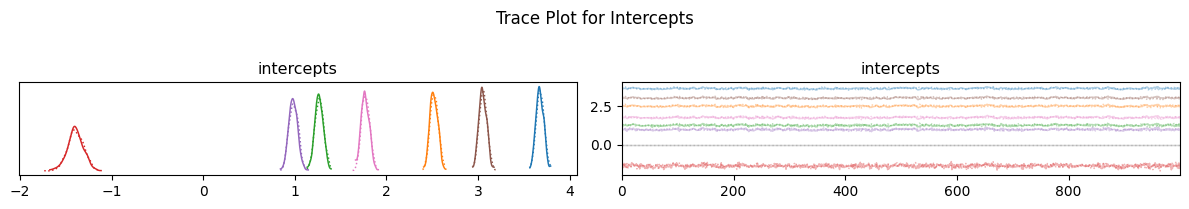

c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


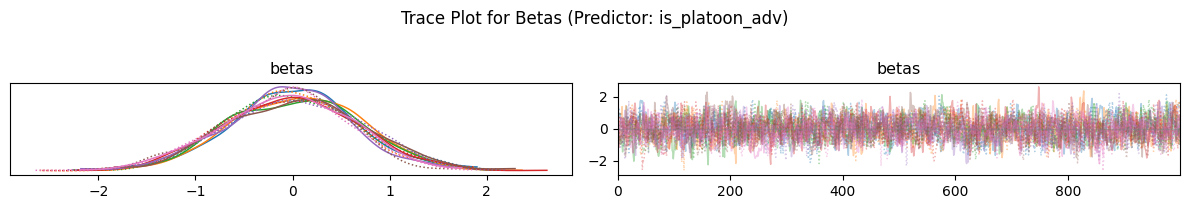

In [8]:
# Trace plot for intercepts
# You might need to select specific coordinates if the dimensions are large
az.plot_trace(idata, var_names=["intercepts"])
plt.suptitle("Trace Plot for Intercepts", y=1.02)
plt.tight_layout()
plt.show()

# Trace plot for a specific beta (e.g., first predictor, all outcome categories)
# To make this more meaningful, you need to know the mapping of beta indices to predictor names
# and outcome categories.
# Example: idata.posterior["betas"].isel(betas_dim_0=0) # Selects the first predictor's betas
if "betas" in idata.posterior:
    try:
        # Adjust 'betas_dim_0' to your actual predictor dimension name in the .nc file
        # This plots betas for the first predictor across all its outcome dimensions
        az.plot_trace(idata, var_names=["betas"], coords={"betas_dim_0": [0]}) # Plot for the first predictor
        plt.suptitle(f"Trace Plot for Betas (Predictor: {predictor_names[0]})", y=1.02)
        plt.tight_layout()
        plt.show()

        # Plot for a specific beta and a specific outcome dimension
        # Adjust 'pa_outcome_category_dim_0' to your actual outcome dimension name
        # az.plot_trace(idata, var_names=["betas"], coords={"betas_dim_0": [0], "pa_outcome_category_dim_0": [0]})
        # plt.suptitle(f"Trace Plot for Betas (Predictor: {predictor_names[0]}, Outcome: {outcome_param_labels[0]})", y=1.02)
        # plt.tight_layout()
        # plt.show()
    except Exception as e:
        print(f"Could not plot trace for betas, check dimension names: {e}")

In [ ]:
# For easy reference to outcome labels and predictor names
outcome_labels_map = config.OUTCOME_LABELS
predictor_names_list = config.PREDICTOR_COLS # This is your list of predictor names

# Your identified dimension names
predictor_dim_name_in_idata = 'betas_dim_0'
outcome_dim_name_in_idata = 'betas_dim_1'

# --- Example: Plotting for a specific predictor ---
if "betas" in idata.posterior:
    # Choose a predictor to analyze by its index from config.PREDICTOR_COLS
    predictor_index_to_analyze = 0  # e.g., the first predictor
    if predictor_index_to_analyze < len(predictor_names_list):
        predictor_name_to_analyze = predictor_names_list[predictor_index_to_analyze]

        print(f"\nAnalyzing betas for predictor: '{predictor_name_to_analyze}' (index {predictor_index_to_analyze})")

        # Extract the betas for this specific predictor
        # .isel() selects data along a dimension by its integer index
        betas_for_one_predictor = idata.posterior["betas"].isel(
            {predictor_dim_name_in_idata: predictor_index_to_analyze}
        )
        # Now, betas_for_one_predictor has dimensions (chain, draw, betas_dim_1)

        # Create meaningful labels for the outcome dimension coordinates
        # The coordinates for 'betas_dim_1' are [0, 1, ..., 7]
        # We want to map these to ["Out_In_Play", "Single", ...]
        
        # Get the size of the outcome dimension from the data
        num_outcome_params_in_betas = betas_for_one_predictor.sizes[outcome_dim_name_in_idata]
        
        # Create labels based on config.OUTCOME_LABELS, matching the dimension size
        actual_outcome_labels_for_plot = [
            outcome_labels_map[i] for i in range(num_outcome_params_in_betas)
        ]

        # Assign these string labels as coordinates for the outcome dimension
        betas_for_one_predictor_labelled = betas_for_one_predictor.assign_coords(
            {outcome_dim_name_in_idata: actual_outcome_labels_for_plot}
        )

        # Now plot using the labelled DataArray
        az.plot_forest(
            betas_for_one_predictor_labelled, 
            combined=True, 
            hdi_prob=0.95,
            figsize=(6, 4),  # Try different values, e.g., (12, 8) or (10, 5)
        )
        plt.title(f"Effect of '{predictor_name_to_analyze}' on Log-Odds of Outcomes")
        plt.show()

        az.plot_posterior(betas_for_one_predictor_labelled, figsize=(12, 10),)
        plt.suptitle(f"Posterior of Betas for '{predictor_name_to_analyze}' by Outcome", y=1.02)
        # plt.tight_layout() # You might need to manage layout if there are many outcomes
        plt.show()

    else:
        print(f"Predictor index {predictor_index_to_analyze} is out of range for predictor_names_list.")
else:
    print("'betas' not found in idata.posterior")



In [ ]:
# You can do something similar for "intercepts"
if "intercepts" in idata.posterior:
    intercepts_data_array = idata.posterior["intercepts"]
    # Find the outcome dimension name for intercepts (likely similar to betas_dim_1 or a unique name)
    # Example: outcome_dim_name_for_intercepts = 'intercepts_dim_0' # CHECK THIS from intercepts_data_array.dims
    
    # Assuming the outcome dimension for intercepts is 'intercepts_dim_0' and has size 8
    # Check actual dimension name:
    intercept_dims = intercepts_data_array.dims
    print(f"Dimensions of 'intercepts': {intercept_dims}") #e.g., ('chain', 'draw', 'intercepts_dim_0')
    
    # Find the non-chain, non-draw dimension name for intercepts
    outcome_dim_name_for_intercepts = None
    for dim in intercept_dims:
        if dim not in ['chain', 'draw']:
            outcome_dim_name_for_intercepts = dim
            break
            
    if outcome_dim_name_for_intercepts:
        num_intercept_params = intercepts_data_array.sizes[outcome_dim_name_for_intercepts]
        actual_intercept_labels_for_plot = [
            outcome_labels_map[i] for i in range(num_intercept_params)
        ]

        intercepts_labelled = intercepts_data_array.assign_coords(
            {outcome_dim_name_for_intercepts: actual_intercept_labels_for_plot}
        )

        az.plot_posterior(intercepts_labelled)
        plt.suptitle("Posterior Distributions for Intercepts by Outcome", y=1.02)
        plt.show()
    else:
        print("Could not determine outcome dimension for intercepts automatically.")

In [9]:
# Posterior plot for intercepts
az.plot_posterior(idata, var_names=["intercepts"])
plt.suptitle("Posterior Distributions for Intercepts", y=1.02)
plt.tight_layout()
plt.show()

# Posterior plot for betas of a specific predictor
if "betas" in idata.posterior:
    try:
        # Adjust 'betas_dim_0' to your actual predictor dimension name
        az.plot_posterior(idata, var_names=["betas"], coords={"betas_dim_0": [0]})
        plt.suptitle(f"Posterior Distributions for Betas (Predictor: {predictor_names[0]})", y=1.02)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot posterior for betas, check dimension names: {e}")

c:\Users\samba\OneDrive\Python_Projects\first_3_innings_model\.venv\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\samba\AppData\Local\Temp\ipykernel_65936\391669006.py:4: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


C:\Users\samba\AppData\Local\Temp\ipykernel_65936\391669006.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


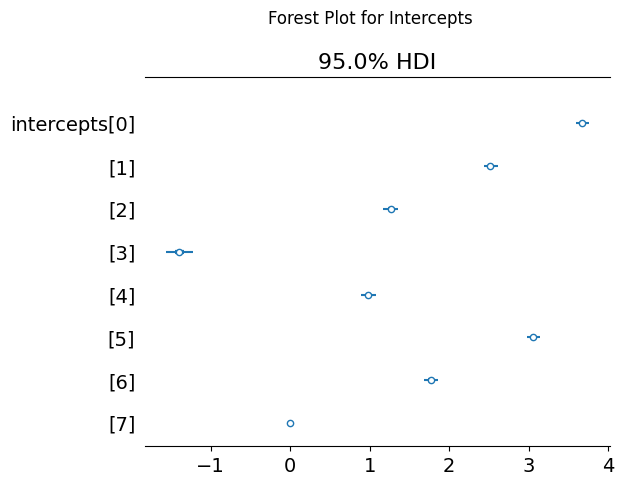

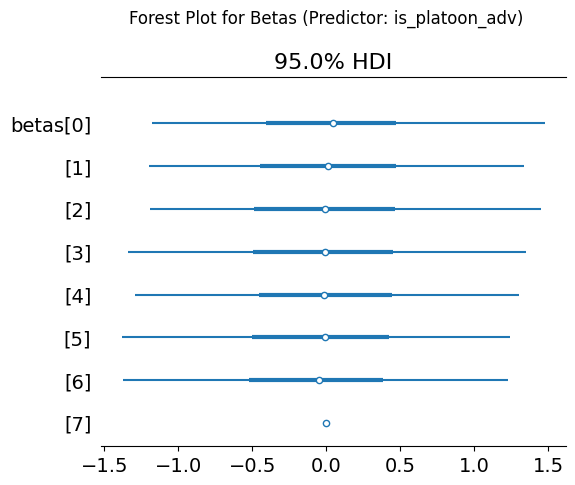

In [10]:
# Forest plot for intercepts
az.plot_forest(idata, var_names=["intercepts"], combined=True, hdi_prob=0.95)
plt.suptitle("Forest Plot for Intercepts", y=1.02)
plt.show()

# Forest plot for betas of a specific predictor, across outcome categories
if "betas" in idata.posterior:
    try:
        # Adjust 'betas_dim_0' to your actual predictor dimension name
        az.plot_forest(idata, var_names=["betas"], coords={"betas_dim_0": [0]}, combined=True, hdi_prob=0.95)
        plt.suptitle(f"Forest Plot for Betas (Predictor: {predictor_names[0]})", y=1.02)
        plt.show()
    except Exception as e:
        print(f"Could not create forest plot for betas: {e}")

In [ ]:
if "betas" in idata.posterior and predictor_names and outcome_param_labels:
    # Choose a predictor to analyze, e.g., the second predictor
    predictor_index_to_analyze = 1 # Change as needed
    predictor_to_analyze = predictor_names[predictor_index_to_analyze]

    # Extract the betas for this specific predictor across all outcome dimensions
    # Adjust 'betas_dim_0' to your actual predictor dimension name in the .nc file
    specific_betas = idata.posterior["betas"].isel(betas_dim_0=predictor_index_to_analyze)
    print(1, specific_betas)
    # Rename the outcome dimension for better plot labels if ArviZ doesn't pick it up automatically
    # This step is crucial if the dimension name is generic like 'pa_outcome_category_dim_0'
    # You need to find the correct name for your outcome dimension in specific_betas.dims
    outcome_dim_name_in_betas = 'd' # REPLACE with actual dim name if different
    
    if outcome_dim_name_in_betas in specific_betas.dims:
        # Ensure the labels match the size of the dimension
        current_outcome_dim_size = specific_betas.sizes[outcome_dim_name_in_betas]
        applicable_outcome_labels = outcome_param_labels[:current_outcome_dim_size]

        specific_betas_renamed = specific_betas.assign_coords(
            {outcome_dim_name_in_betas: applicable_outcome_labels}
        )
        
        az.plot_forest(specific_betas_renamed, combined=True, hdi_prob=0.95)
        plt.title(f"Effect of '{predictor_to_analyze}' on Log-Odds of Outcomes")
        plt.show()

        az.plot_posterior(specific_betas_renamed)
        plt.suptitle(f"Posterior of Betas for '{predictor_to_analyze}' by Outcome", y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Dimension '{outcome_dim_name_in_betas}' not found in betas for predictor '{predictor_to_analyze}'. Available dims: {specific_betas.dims}")

1 <xarray.DataArray 'betas' (chain: 2, draw: 1000, betas_dim_1: 8)> Size: 128kB
array([[[ 0.322486,  0.111399, ..., -0.099379,  0.      ],
        [ 0.3092  ,  0.122492, ..., -0.132703,  0.      ],
        ...,
        [-0.345164,  0.064945, ..., -0.212759,  0.      ],
        [ 0.00327 ,  0.100472, ..., -0.045133,  0.      ]],

       [[ 0.474858,  0.308405, ..., -0.264769,  0.      ],
        [ 0.405164,  0.092555, ..., -0.314658,  0.      ],
        ...,
        [ 0.598625,  0.587089, ..., -0.006934,  0.      ],
        [ 0.539678,  0.202295, ...,  0.064614,  0.      ]]], shape=(2, 1000, 8))
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
    betas_dim_0  int64 8B 1
  * betas_dim_1  (betas_dim_1) int64 64B 0 1 2 3 4 5 6 7
Dimension 'outcome_dim_0' not found in betas for predictor 'is_batter_home'. Available dims: ('chain', 'draw', 'betas_dim_1')
